In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, PowerTransformer, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, r2_score


In [33]:
df = pd.read_csv("loan_data.csv")
df.head(5)

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


In [34]:
print(df.info())
print(df.describe())
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  float64
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   45000 non-null  float64
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45000 non-null  float64
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  float64
 11  credit_score                    45000 non-null  int64  
 12  previous_loan_defaults_on_file  

In [35]:
print(df.shape)
print(df.duplicated().sum())


(45000, 14)
0


In [36]:
categorical_cols = ['person_gender', 'person_education', 'person_home_ownership', 'loan_intent', 'previous_loan_defaults_on_file']
numeric_cols = ['person_age', 'person_income', 'person_emp_exp', 'loan_amnt', 'loan_int_rate', 
                'loan_percent_income', 'cb_person_cred_hist_length', 'credit_score']

# Fill missing categorical values
for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

# Fill missing numeric values
for col in numeric_cols:
    df[col] = df[col].fillna(df[col].median())

# -----------------------------
# Step 4: Encode categorical features
# -----------------------------
le = LabelEncoder()
for col in categorical_cols + ['loan_status']:
    df[col] = le.fit_transform(df[col])

# Ensure all data is numeric
df = df.apply(pd.to_numeric)

In [37]:
print("Skewness before transformation:\n", df[numeric_cols].skew())

Skewness before transformation:
 person_age                     2.548154
person_income                 34.137583
person_emp_exp                 2.594917
loan_amnt                      1.179731
loan_int_rate                  0.213784
loan_percent_income            1.034512
cb_person_cred_hist_length     1.631720
credit_score                  -0.610261
dtype: float64


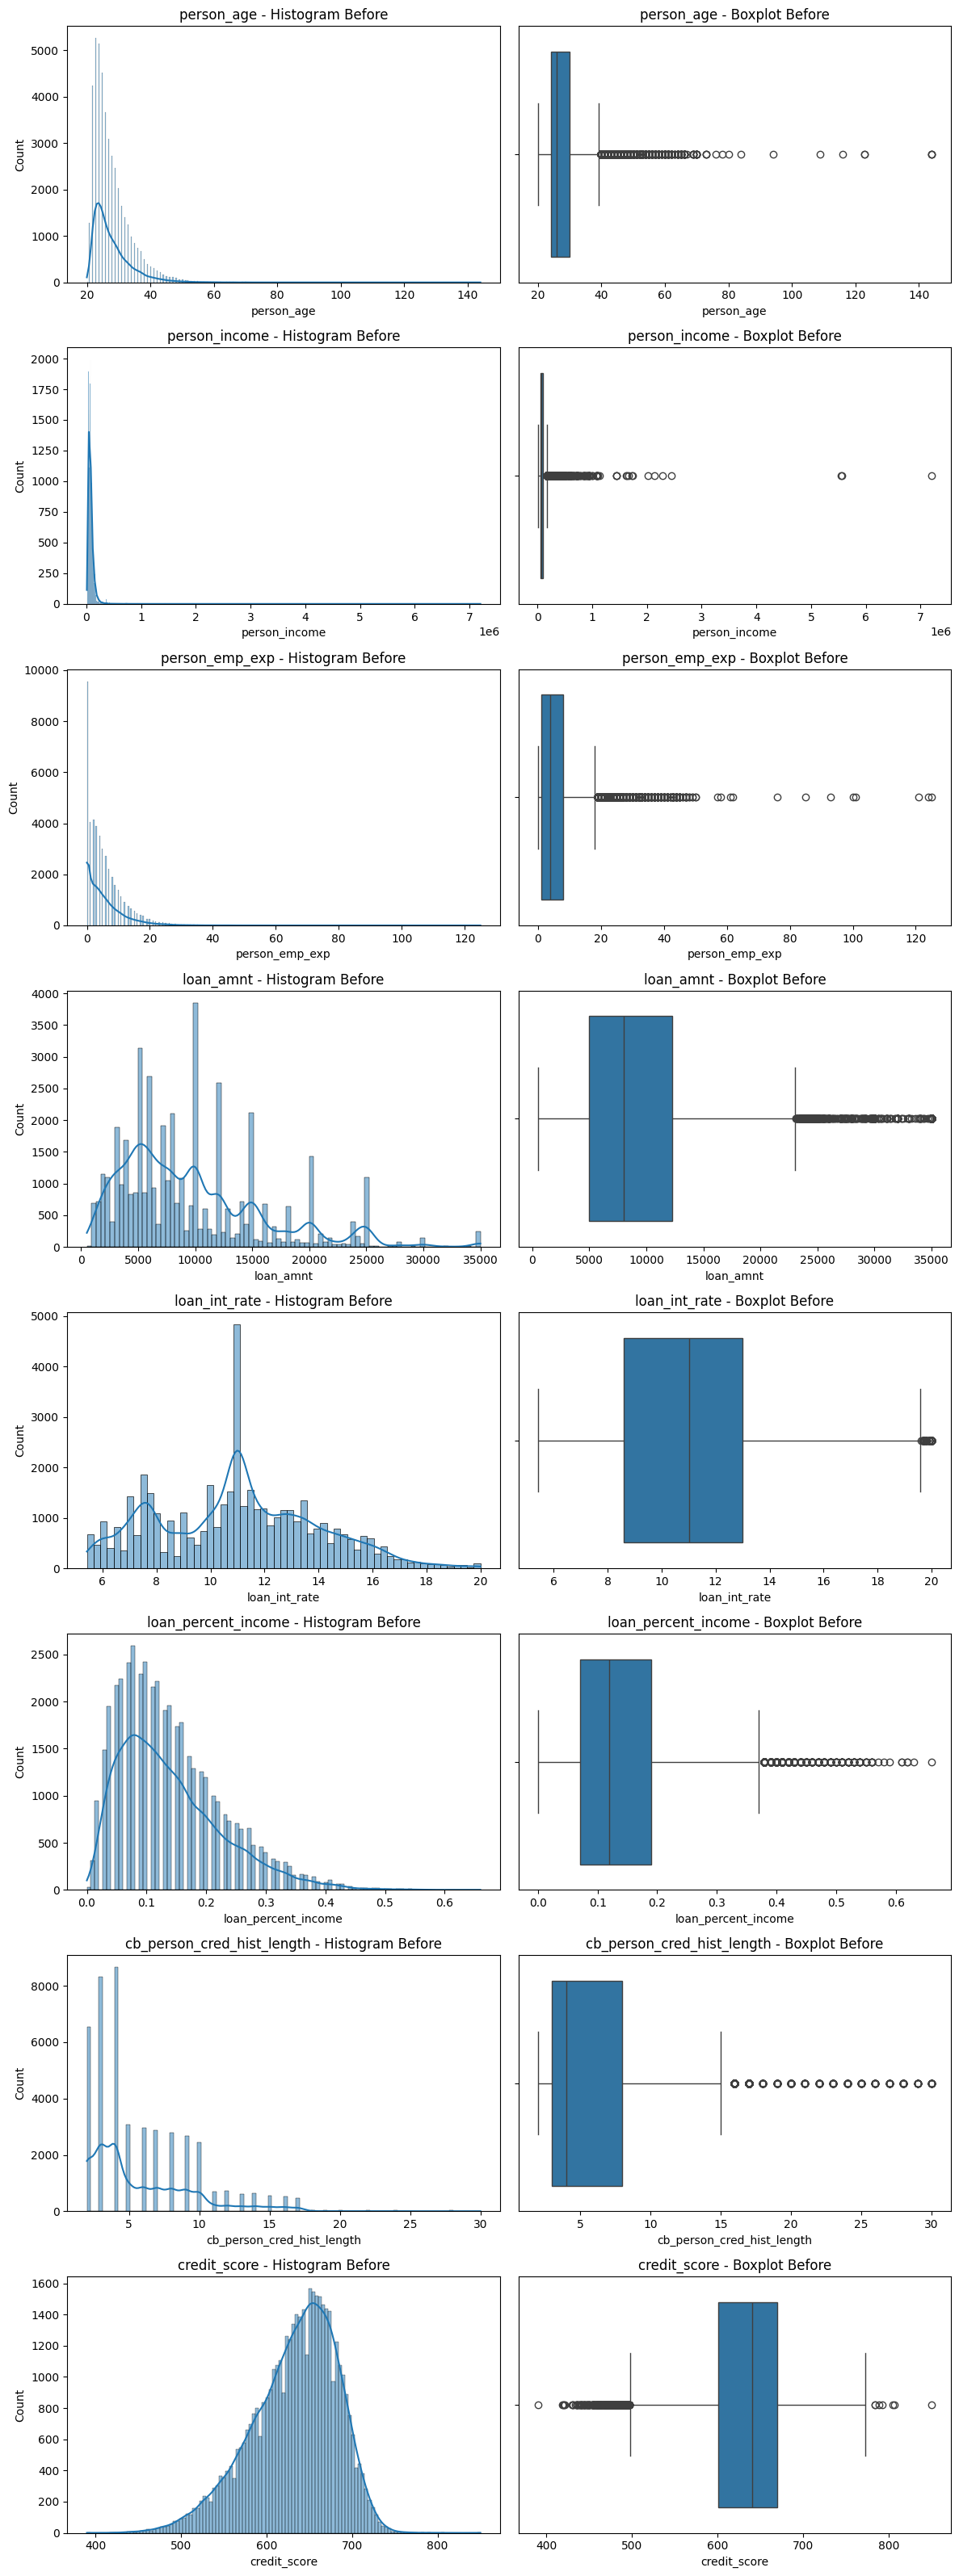

In [38]:
n = len(numeric_cols)
fig, axes = plt.subplots(n, 2, figsize=(12, 4*n))
for i, col in enumerate(numeric_cols):
    sns.histplot(df[col], kde=True, ax=axes[i,0])
    axes[i,0].set_title(f"{col} - Histogram Before")
    
    sns.boxplot(x=df[col], ax=axes[i,1])
    axes[i,1].set_title(f"{col} - Boxplot Before")

plt.tight_layout()
plt.show()

In [39]:
pt = PowerTransformer()
df[numeric_cols] = pt.fit_transform(df[numeric_cols])
print("Skewness after transformation:\n", df[numeric_cols].skew())

Skewness after transformation:
 person_age                    0.139352
person_income                -0.017895
person_emp_exp               -0.021322
loan_amnt                    -0.021640
loan_int_rate                -0.029283
loan_percent_income           0.091310
cb_person_cred_hist_length    0.073157
credit_score                 -0.044067
dtype: float64


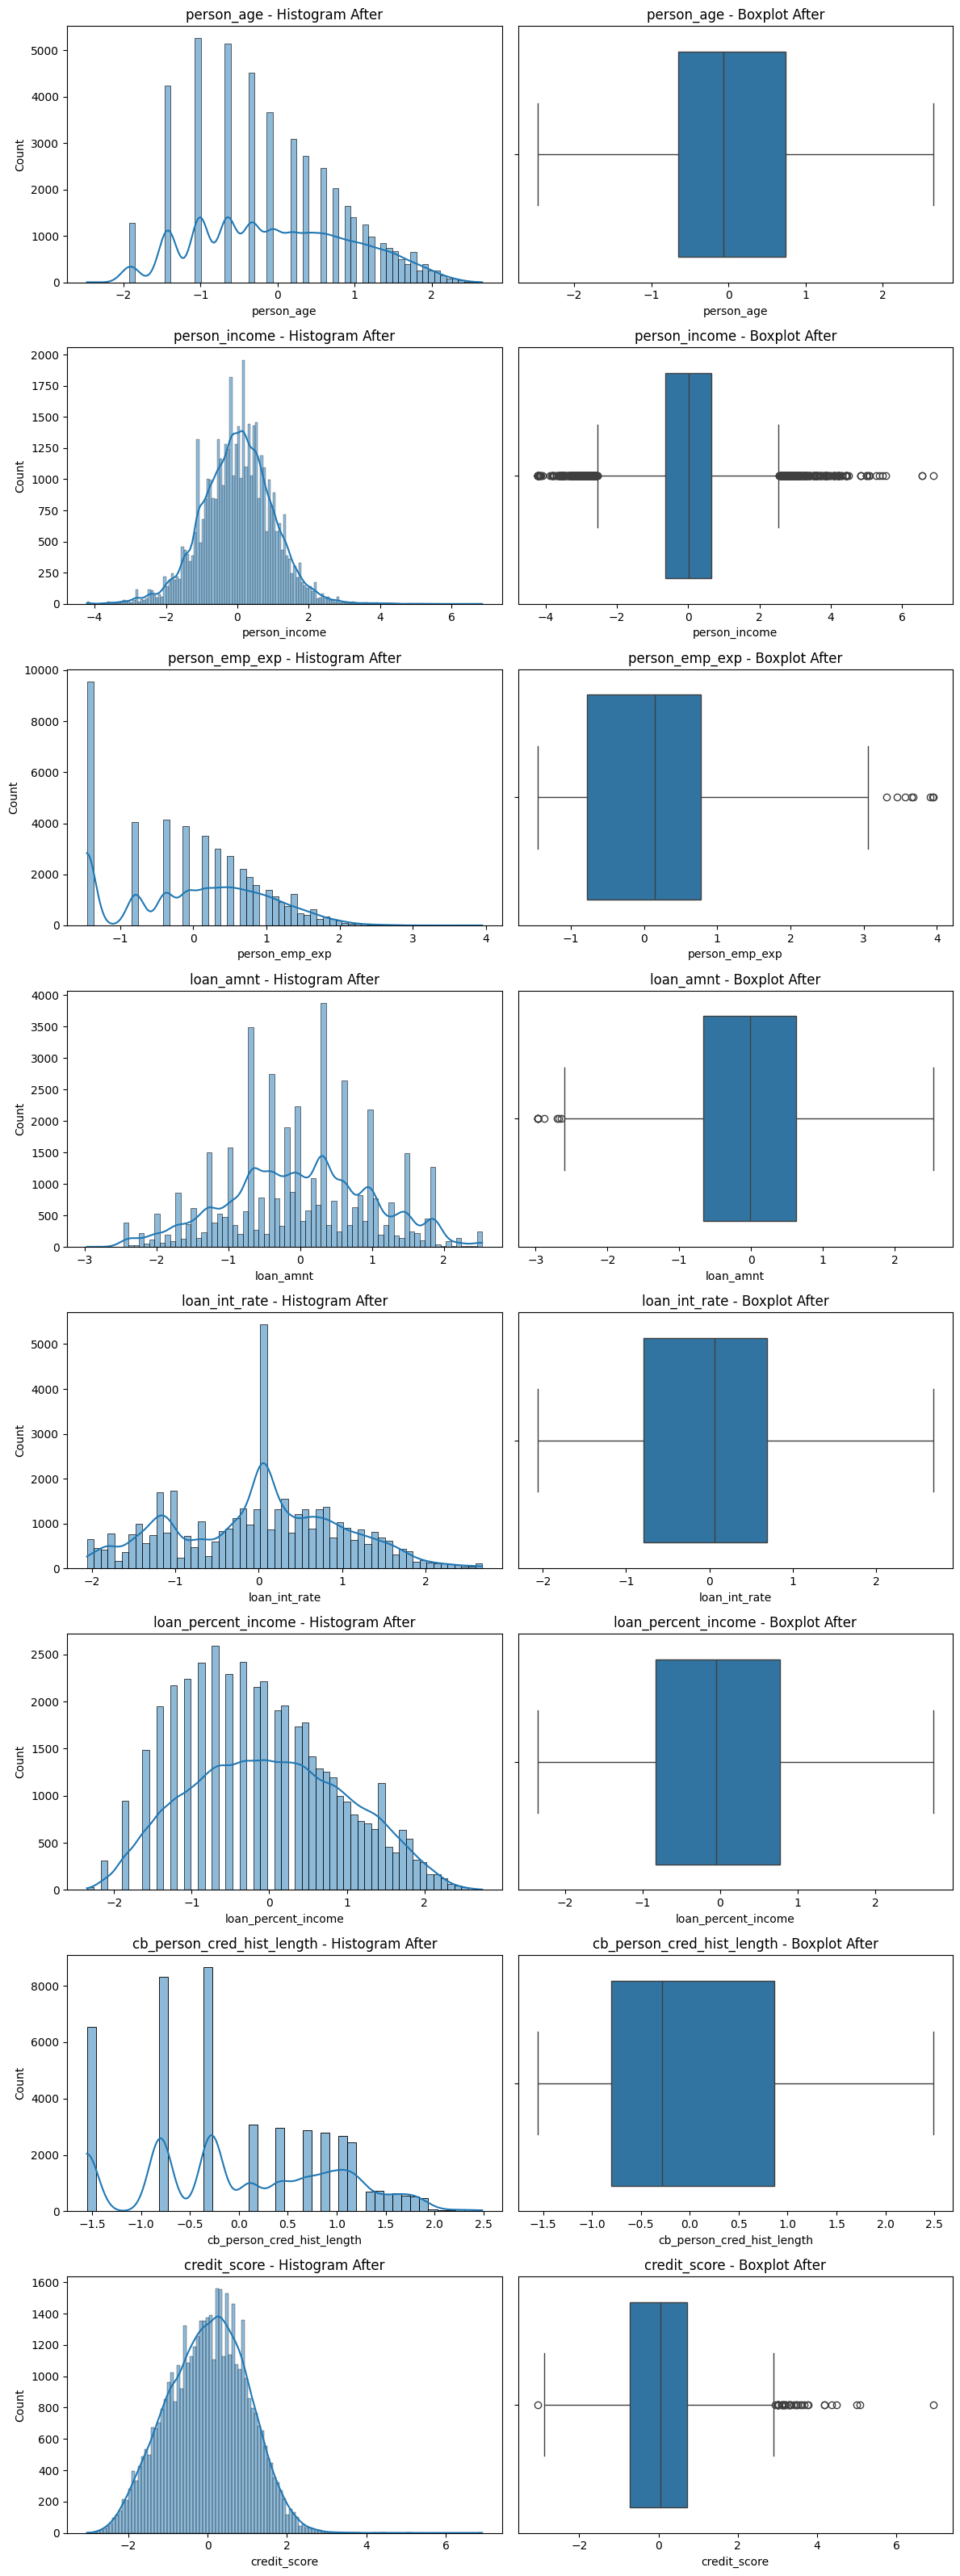

In [40]:
fig, axes = plt.subplots(n, 2, figsize=(12, 4*n))
for i, col in enumerate(numeric_cols):
    sns.histplot(df[col], kde=True, ax=axes[i,0])
    axes[i,0].set_title(f"{col} - Histogram After")
    
    sns.boxplot(x=df[col], ax=axes[i,1])
    axes[i,1].set_title(f"{col} - Boxplot After")

plt.tight_layout()
plt.show()

In [41]:

numeric_cols = ['person_age', 'person_income', 'person_emp_exp', 
                'loan_amnt', 'loan_int_rate', 'loan_percent_income', 
                'cb_person_cred_hist_length', 'credit_score']

# Make a copy of original numeric data
numeric_original = df[numeric_cols].copy()

# Function to count outliers using IQR
def count_outliers(df, cols, factor=1.5):
    outlier_counts = {}
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        outliers = df[(df[col] < Q1 - factor*IQR) | (df[col] > Q3 + factor*IQR)]
        outlier_counts[col] = outliers.shape[0]
    return outlier_counts

# ===== Outliers BEFORE transformation =====
outliers_before = count_outliers(numeric_original, numeric_cols)

# ===== Apply Power Transformation =====
pt = PowerTransformer()
numeric_transformed = pd.DataFrame(pt.fit_transform(numeric_original), columns=numeric_cols)

# ===== Outliers AFTER transformation =====
outliers_after = count_outliers(numeric_transformed, numeric_cols)

# ===== Cap remaining outliers after transformation =====
for col in numeric_cols:
    Q1 = numeric_transformed[col].quantile(0.25)
    Q3 = numeric_transformed[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5*IQR
    upper = Q3 + 1.5*IQR
    numeric_transformed[col] = numeric_transformed[col].clip(lower, upper)

# ===== Outliers AFTER transformation + capping =====
outliers_after_capping = count_outliers(numeric_transformed, numeric_cols)

# ===== Display results =====
outlier_table = pd.DataFrame({
    'Outliers Before Transformation': outliers_before,
    'Outliers After Transformation': outliers_after,
    'Outliers After Capping': outliers_after_capping
})

print("Outlier Counts Before and After Transformation + Capping:\n")
print(outlier_table)


Outlier Counts Before and After Transformation + Capping:

                            Outliers Before Transformation  \
person_age                                               0   
person_income                                          755   
person_emp_exp                                           8   
loan_amnt                                                9   
loan_int_rate                                            0   
loan_percent_income                                      0   
cb_person_cred_hist_length                               0   
credit_score                                            40   

                            Outliers After Transformation  \
person_age                                              0   
person_income                                         795   
person_emp_exp                                         10   
loan_amnt                                               9   
loan_int_rate                                           0   
loan_percent_inc

In [42]:
X = df.drop('loan_status', axis=1)
y = df['loan_status'].astype(int)  # ensure 1D int array

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [43]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)


Random Forest Metrics:
Accuracy: 0.9276666666666666
Precision: 0.8858603066439523
Recall: 0.7761194029850746
F1 Score: 0.8273667462211615


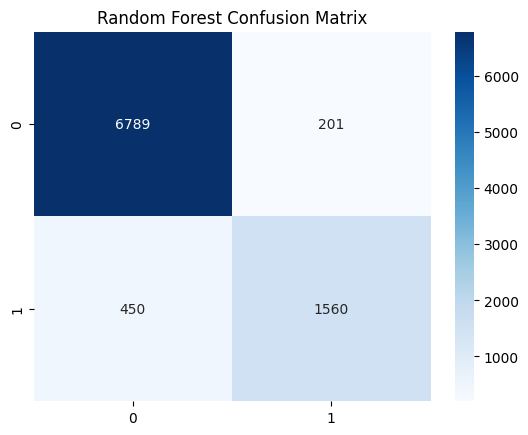

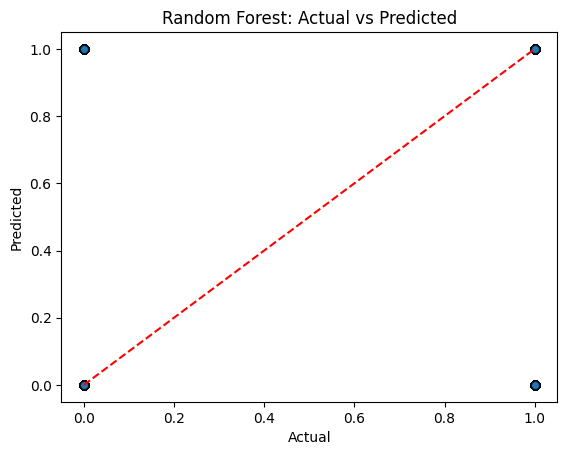

In [46]:
print("Random Forest Metrics:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf))
print("Recall:", recall_score(y_test, y_pred_rf))
print("F1 Score:", f1_score(y_test, y_pred_rf))

cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues')
plt.title("Random Forest Confusion Matrix")
plt.show()

plt.scatter(y_test, y_pred_rf, alpha=0.6, edgecolors='k')
plt.plot([0,1],[0,1], color='red', linestyle='--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Random Forest: Actual vs Predicted")
plt.show()


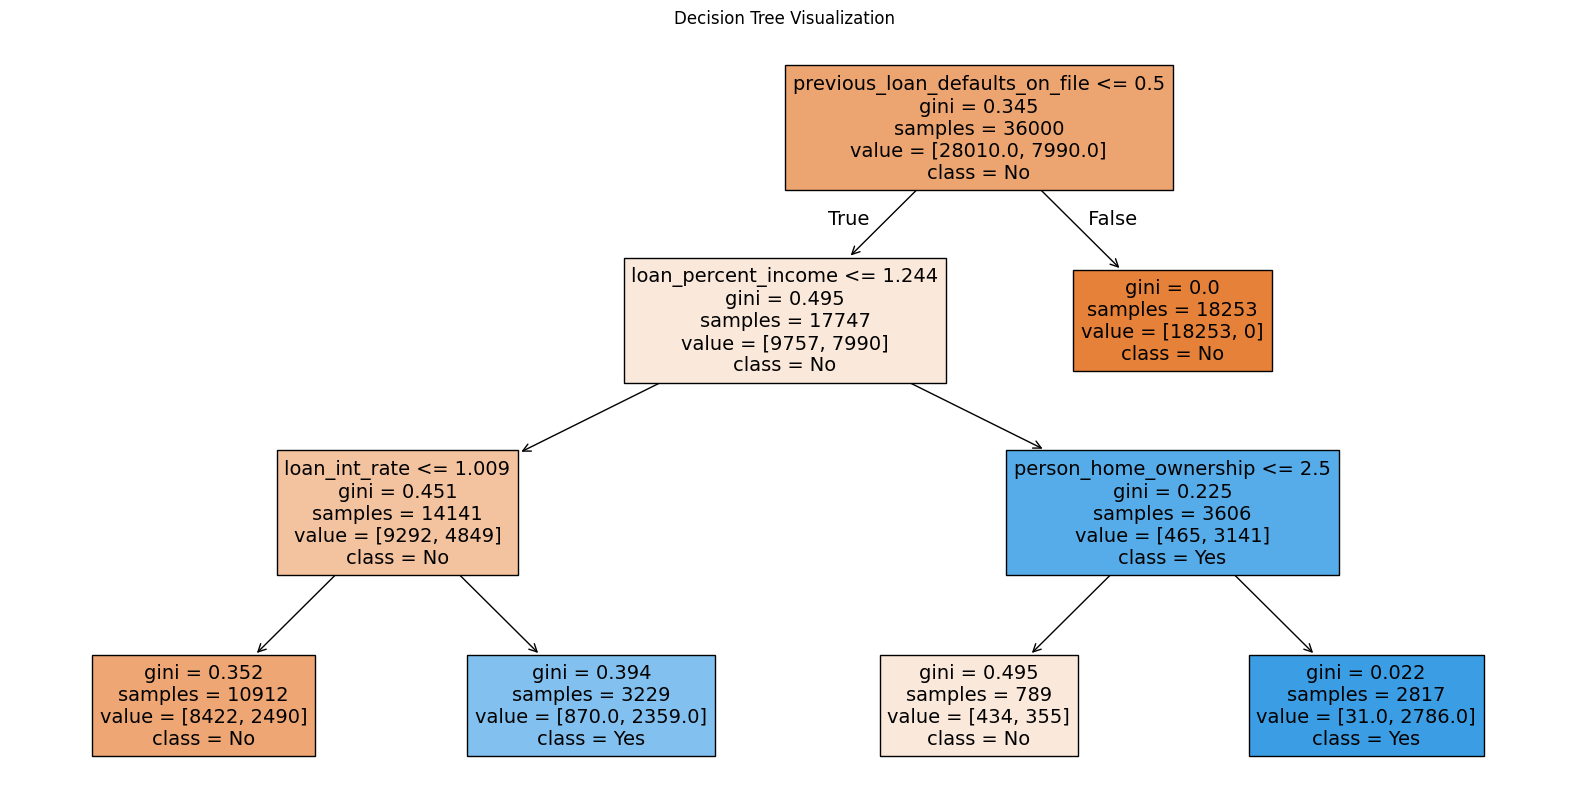

In [48]:
dt = DecisionTreeClassifier(max_depth=3, random_state=42)
dt.fit(X_train, y_train)
plt.figure(figsize=(20,10))
plot_tree(dt, feature_names=X.columns, class_names=['No','Yes'], filled=True)
plt.title("Decision Tree Visualization")
plt.show()

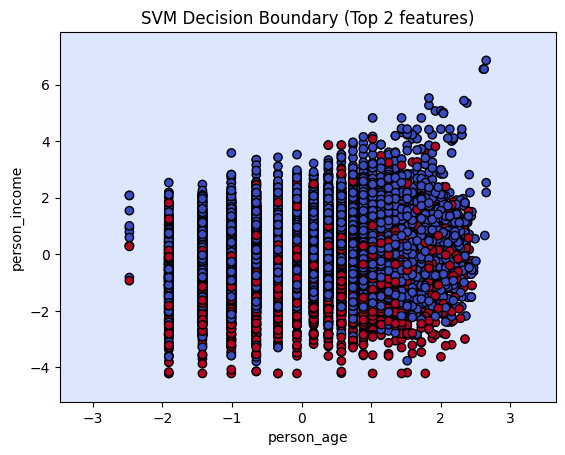

In [49]:
top_features = numeric_cols[:2]  # e.g., person_age, person_income
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[top_features])
X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

svm_model = SVC(kernel='linear', probability=True)
svm_model.fit(X_train_svm, y_train_svm)

xx, yy = np.meshgrid(np.linspace(X_train_svm[:,0].min()-1, X_train_svm[:,0].max()+1, 100),
                     np.linspace(X_train_svm[:,1].min()-1, X_train_svm[:,1].max()+1, 100))
Z = svm_model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
plt.scatter(X_train_svm[:,0], X_train_svm[:,1], c=y_train_svm, edgecolors='k', cmap='coolwarm')
plt.xlabel(top_features[0])
plt.ylabel(top_features[1])
plt.title("SVM Decision Boundary (Top 2 features)")
plt.show()
